## Author: Chia-Yun (Sandy) Chiang

## Introduction

In this project, I used the Earth Surface Temperature Data from Kaggle ([source](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalTemperatures.csv)). I'll use this dataset for monthly temperature prediction in future years.

## Setup

In [48]:
!pip install -q --upgrade pmdarima;
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
%matplotlib inline

In [52]:
plt.rcParams["figure.figsize"] = (24,8)

In [3]:
climate_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRkuaP4nTWk1V7v3BxtDYpoBcEsDLFD0b3oOhG7H4l7i5lAwBuqWEhc3ipegB4FJh6Hi64t4fif5Xrp/pub?gid=1201739575&single=true&output=csv"
df = pd.read_csv(climate_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


In [5]:
df.isnull().sum()

dt                                              0
LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

In [6]:
# drop the column which not in our scope
remain_column = ["dt", "LandAverageTemperature"]
df.drop(columns = [x for x in df if x not in remain_column], inplace=True)

In [7]:
date_range = pd.date_range("1750-01-01", "2015-12-01", freq="MS")
date_range

DatetimeIndex(['1750-01-01', '1750-02-01', '1750-03-01', '1750-04-01',
               '1750-05-01', '1750-06-01', '1750-07-01', '1750-08-01',
               '1750-09-01', '1750-10-01',
               ...
               '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
               '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01',
               '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', length=3192, freq='MS')

In [8]:
df["dt"] = pd.DataFrame(date_range)

In [9]:
df = df.set_index("dt")

In [10]:
df.head(3)

,LandAverageTemperature
dt,
1750-01-01,3.034
1750-02-01,3.083
1750-03-01,5.626


- I'll use latest 20 years data

In [11]:
df_target = df.LandAverageTemperature[-240:]

In [12]:
df_target.isnull().sum()

0

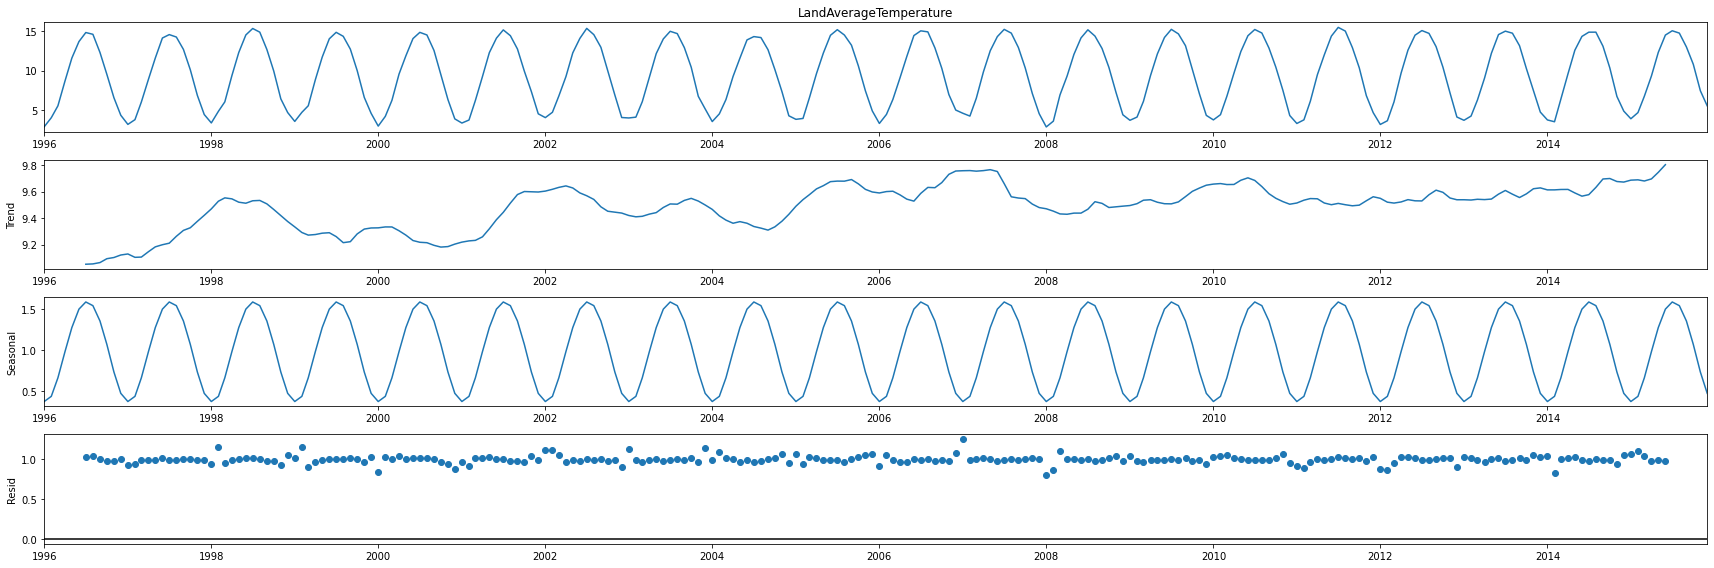

In [13]:
# decompose dataset
res = sm.tsa.seasonal_decompose(df_target, model="multiplicative")
resplot = res.plot()

## Check Stationary using Augmented Dickey-Fuller test

H0: non-stationary   
H1: stationary

**Reference**
- [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/)

In [14]:
# Augmented Dickey-Fuller test
p_value = adfuller(df_target, autolag="AIC")[1]
adf_statistic = adfuller(df_target, autolag="AIC")[0]
critical_value = adfuller(df_target, autolag="AIC")[4]
print("p-value is {}".format(p_value))
print("ADF test statistic {}".format(adf_statistic))
print("Critical value in different confident level: \n", critical_value)

p-value is 0.028073885190962676
ADF test statistic -3.0799386078744933
Critical value in different confident level: 
 {'1%': -3.459884913337196, '5%': -2.8745310704320794, '10%': -2.573693840082908}


- According to Augmented Dickey-Fuller test, we have p-value = 0.028. Also, Our ADF test statistic (-3.08) is less than critical value -2.87, which indicates we have 95% confidence that our data is stationary (Reject H0).
- Since this dataset is stationary, we do not need to stationarize the data.

# ACF & PACF plot

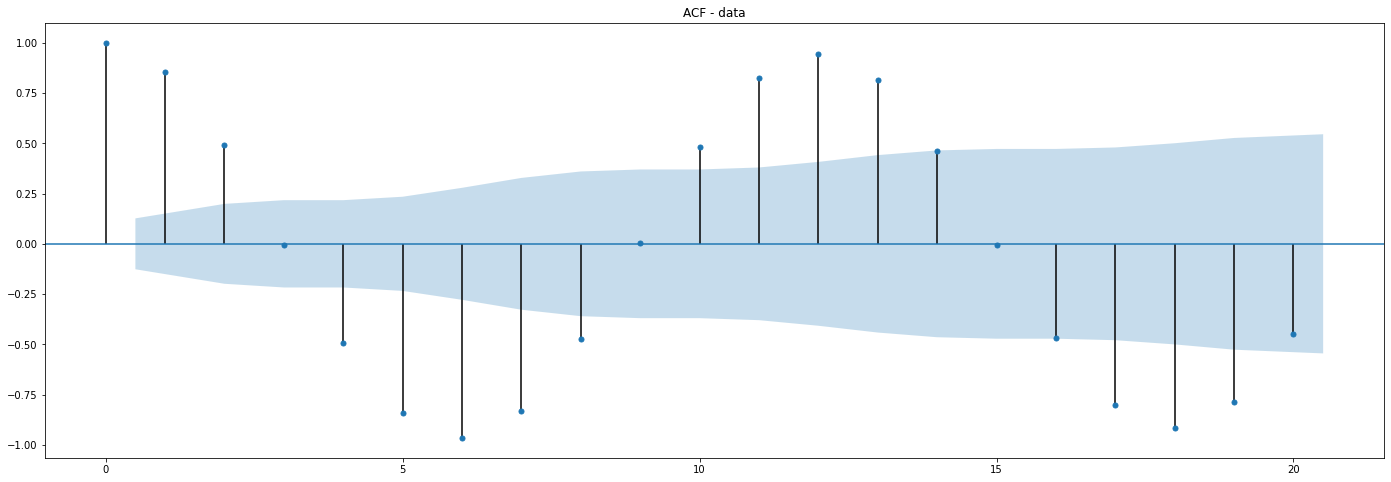

In [20]:
ax = plot_acf(df_target, lags=20, title="ACF - data")

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


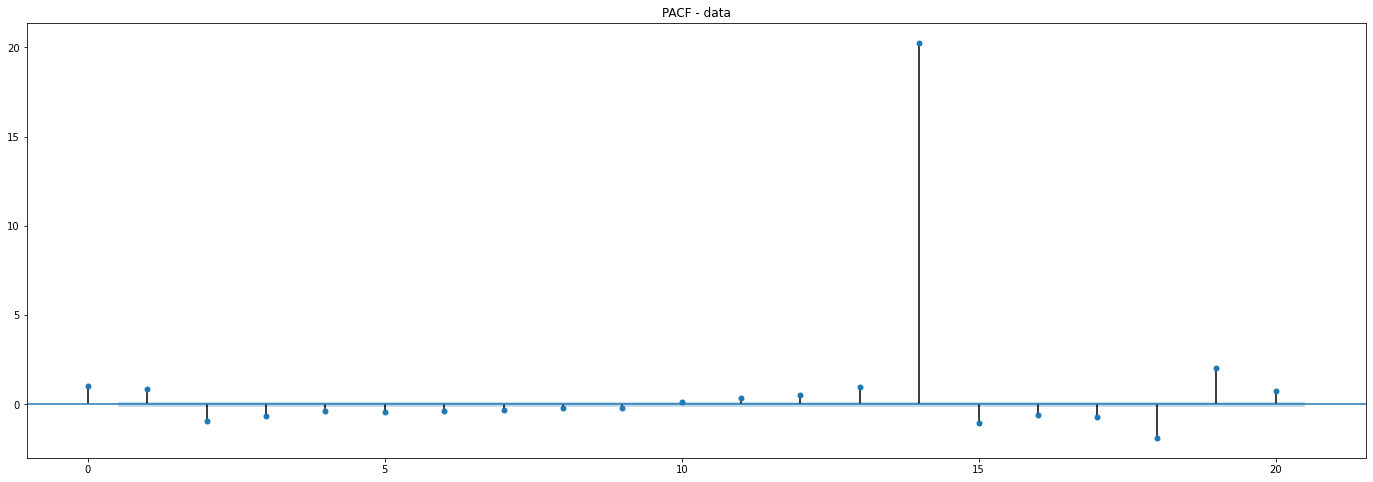

In [21]:
ax = plot_pacf(df_target, lags=20, title="PACF - data")

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


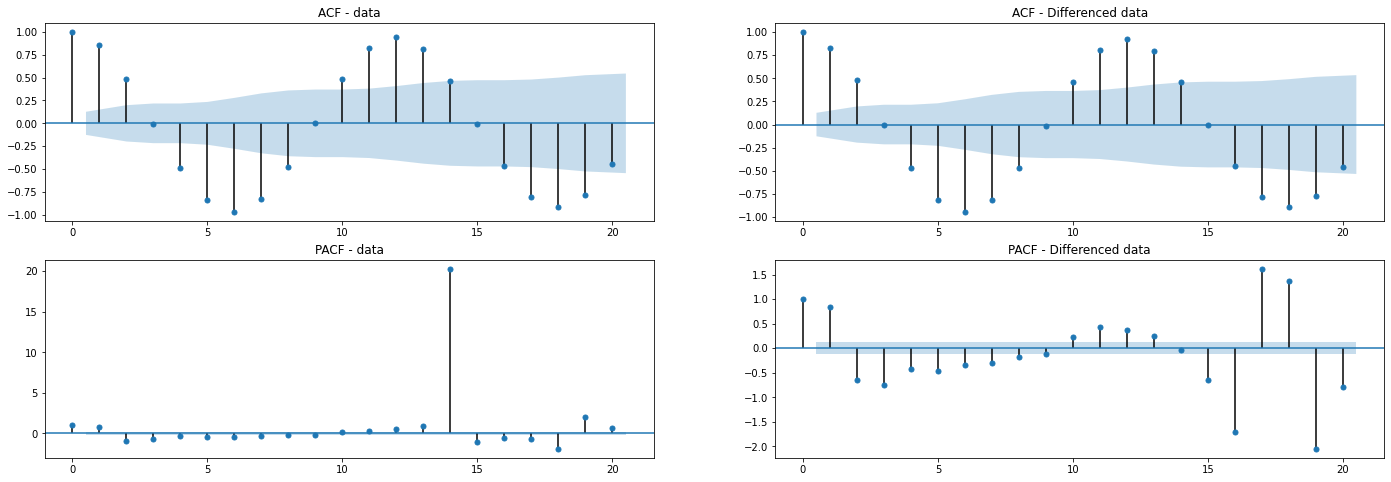

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(24,8))
first_diff = (df_target- df_target.shift()).dropna()
ax[0, 0] = plot_acf(df_target, ax=ax[0, 0], lags=20, title="ACF - data")
ax[1, 0] = plot_pacf(df_target, ax=ax[1, 0], lags=20, title="PACF - data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=20, title="ACF - Differenced data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=20, title="PACF - Differenced data")

## Using ARIMA model for forecasting

**Reference to the methods and code from:**   
- [Python | ARIMA Model for Time Series Forecasting](https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/)

In [25]:
# Auto select the best pqd for ARIMA model
auto_arima_fit = auto_arima(df_target, start_p = 0, start_q = 0, 
                          max_p = 3, max_q = 8, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True) 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=273.172, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=164.597, Time=0.68 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=128.884, Time=0.89 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=273.241, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=259.354, Time=0.15 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=127.341, Time=1.11 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=170.817, Time=0.57 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=128.767, Time=3.36 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=128.225, Time=3.08 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=127.780, Time=2.11 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=154.053, Time=1.32 sec
 ARIMA(0,0,1)(2,1,2)[12] intercept   : AIC=130.222, Time=4.52 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=138.181, Time=0.84 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   

- We use auto_arima function to helps us find the best ARIMA model.
- The bset model has the lowest AIC (~108).

In [27]:
auto_arima_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  240
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 -47.084
Date:                            Mon, 15 Feb 2021   AIC                            108.169
Time:                                    20:33:48   BIC                            132.174
Sample:                                         0   HQIC                           117.854
                                            - 240                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0339      0.011      3.206      0.001       0.013       0.055
ar.L1         -0.4541      0.115     -3.945      0.000      -0.680      -0.229
ar.L2          0.3974      0.055      7.177      0.000       0.289       0.506
ma.L1          0.7405      0.120      6.160      0.000       0.505       0.976
ar.S.L12      -0.2693      0.074     -3.632      0.000      -0.415      -0.124
ma.S.L12      -0.7630      0.064    -11.902      0.000      -0.889      -0.637
sigma2         0.0826      0.008     10.675      0.000       0.067       0.098
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.88   Prob(JB):                         0.88
Heteroskedasticity (H):               0.93   Skew:                             0.07
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Best model: SARIMAX(2, 0, 1)x(1, 1, 1, 12)	

## Fit ARIMA model

In [35]:
# select last year (12 month) data for testing
train_data = df_target.iloc[:len(df_target)-12] 
test_data = df_target.iloc[len(df_target)-12:]
  

sarimax_model = SARIMAX(train_data,  
                order = (2, 0, 1),  
                seasonal_order =(1, 1, 1, 12)) 
  
sarimax_model_result = sarimax_model.fit() 
sarimax_model_result.summary() 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             LandAverageTemperature   No. Observations:                  228
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 -49.966
Date:                            Mon, 15 Feb 2021   AIC                            111.932
Time:                                    21:25:33   BIC                            132.184
Sample:                                01-01-1996   HQIC                           120.114
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6786      0.246      2.763      0.006       0.197       1.160
ar.L2          0.0797      0.118      0.673      0.501      -0.152       0.312
ma.L1         -0.4555      0.235     -1.938      0.053      -0.916       0.005
ar.S.L12      -0.2587      0.084     -3.088      0.002      -0.423      -0.094
ma.S.L12      -0.6983      0.077     -9.023      0.000      -0.850      -0.547
sigma2         0.0876      0.009     10.099      0.000       0.071       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.79   Prob(JB):                         0.96
Heteroskedasticity (H):               0.71   Skew:                             0.04
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prediction for testing data

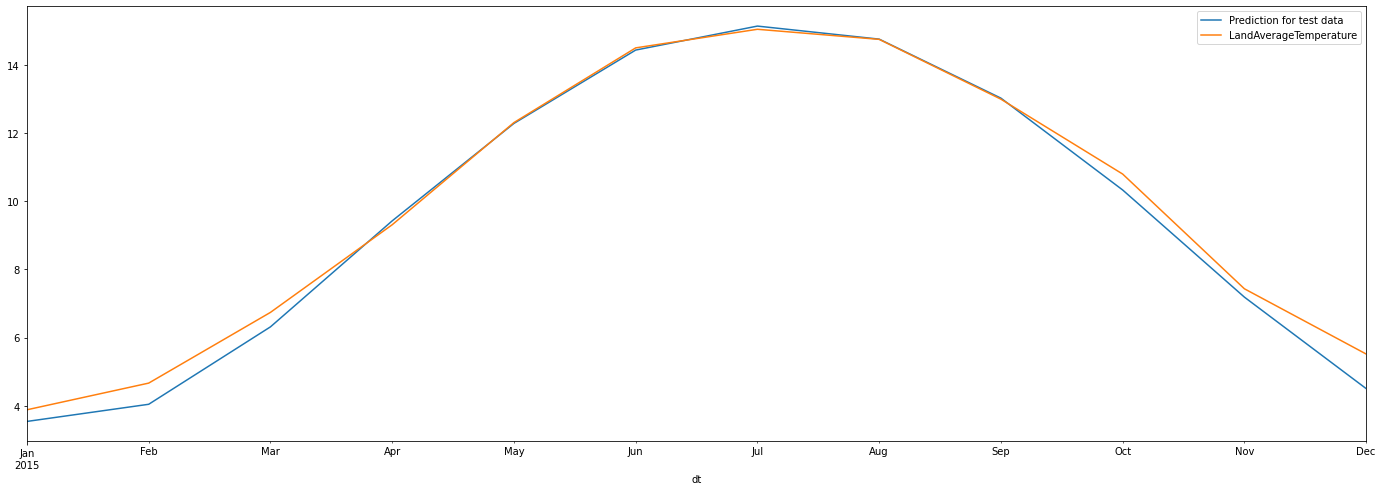

In [53]:
test_start = len(train_data) 
test_end = len(train_data) + len(test_data) - 1
  
# predict for test data
predict_test = result.predict(test_start, test_end, 
                             typ = 'levels').rename("Prediction for test data") 
  
# Plot the test data and prediction to see if both are aligh with each other
predict_test.plot(legend = True) 
test_data.plot(legend = True) 

In [51]:
mse_test = mean_squared_error(test_data, predict_test) 
print("MSE is:", mse_test)

MSE is: 0.16835070919216114


- We have very small MSE for testing data, which indicates this model performing well.

## Forecast for furture year

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


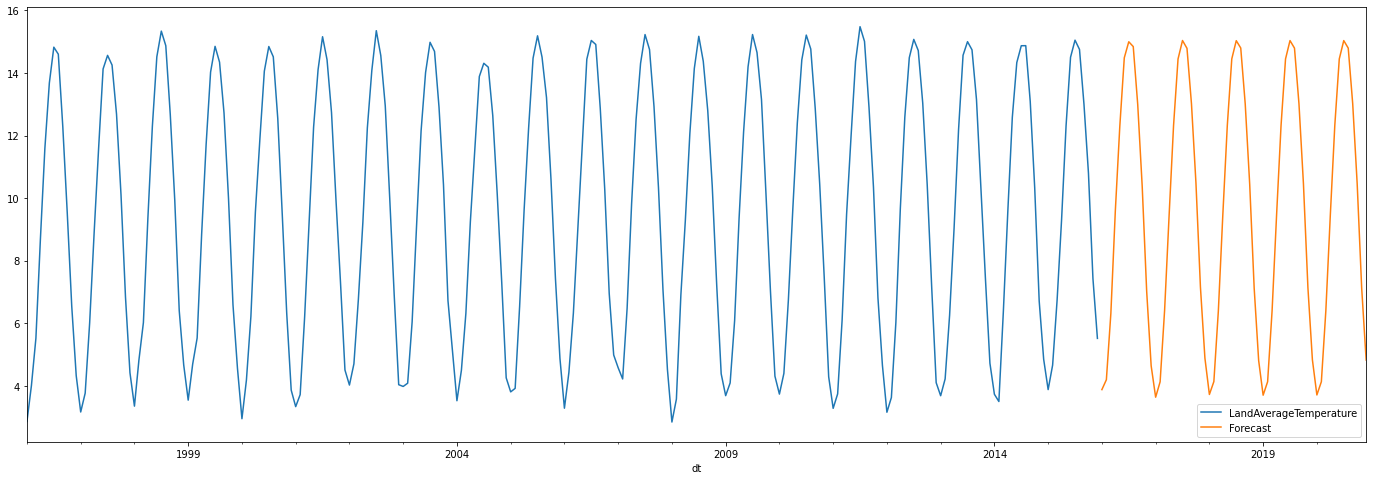

In [54]:
# Fit model with full dataset
sarimax_model_full = SARIMAX(df_target,  
                             order = (2, 0, 1),  
                             seasonal_order =(1, 1, 1, 12)) 
  

sarimax_model_result_full = sarimax_model_full.fit() 
# Forecast for next 5 years
forecast = sarimax_model_result_full.predict(start = len(df_target),  
                                             end = (len(df_target)-1) + 5 * 12,  
                                             typ = 'levels').rename('Forecast') 

df_target.plot(figsize = (24, 8), legend = True) 
forecast.plot(legend = True) 

## Forecast using the methods from class notebook

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

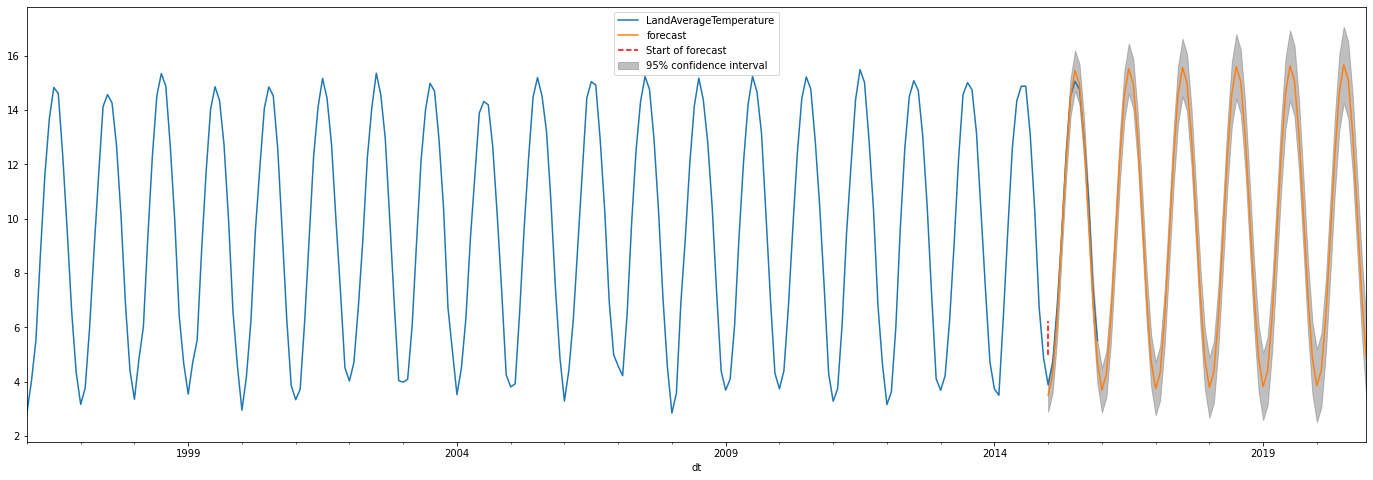

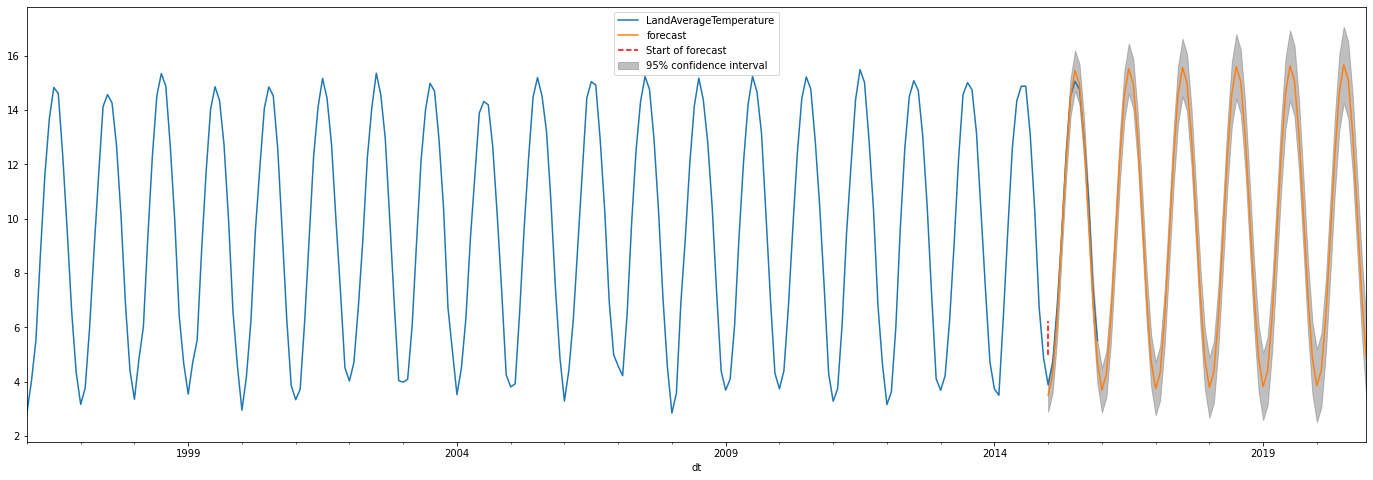

In [55]:
model = ARIMA(df_target.dropna()[:-12], (8,1,2))
res = model.fit()

fig, ax = plt.subplots(figsize=(24, 8));
df_target.dropna()[:].plot(ax=ax);
ax.vlines('2015-01-01', 5, 6.25, linestyle='--', color='r', label='Start of forecast');
res.plot_predict(start = '2015-01-01', end = '2020-12-01', dynamic = True, plot_insample=False, ax=ax)

## Summary
In this exercise, I used the monthly temperature data from 1996-2015 as our input. Then predict for the next 5 years (2015-2020). According to our prediction, we could see that the temperature has the same pattern across different months within a year. June to August has the highest temperature; while December to February has the lowest temperature. Overall, the surface temperature seems very consistent among different months.   

If in the future years, we find the extremely strange temperature in a specific month (for example, July has the surface temperature lower than 10), this might indicate we are very likely to face a huge natural disaster at that time.
